In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pylab

- Simulate the trajectory of a ball with the parameters launch position (especially the height
above an imaginary ground), launch speed and launch angle of the ball.
- Simulate the observation of the ball position (x, y as shown in the slides). The estimated
ball position shall be subject to uncertainty and it shall be possible to parameterize this
uncertainty. In addition, the time span between two observations shall be variable and the
observations shall be able to drop out completely over a certain period of time.
- The initial parameters of the Kalman Filter shall be adaptable.
- The normally distributed noise on transition and observation should be adjustable. This means
that the covariance matrices R and Q shall be set as a parameter in the Kalman Filter.

In [ ]:
def rad_deg(angle):
    return (angle*np.pi)/180

def projectile(launch_speed,angle,height,dt,total_time,g=9.81):
    theta_0 = angle
    v_0 = launch_speed
    h_0 = height
    time_sim = total_time
    step_size = dt
    samples = int(time_sim/step_size)
    time = np.linspace(0,time_sim,samples)
    vx_0 = np.cos(rad_deg(theta_0))*v_0
    vy_0 = np.sin(rad_deg(theta_0))*v_0

    # print(time)
    x = vx_0*time
    y = vy_0*time-g*time**2*0.5+h_0
    vx = np.repeat(vx_0,samples)
    vy = vy_0-g*time
    signal = np.stack((x,y,vx,vy))
    return(signal,time)

def noise_observation(signal,mu,sd):
    noise = np.random.multivariate_normal(mu,sd,signal.shape[1]).T
    signal_n = signal + noise

    return signal_n

def hide_observations(signal,t_0,duration,dt,error_value = -999999):

    i_begin = int(t_0/dt)-1
    i_final = i_begin + int(duration/dt)+1
    # print(i_begin,i_final)
    signal_m = signal.copy()
    #print(type(signal_m))
    # signal_m[0,i_begin:i_final] = error_value
    signal_m[1,i_begin:i_final] = error_value
    return signal_m

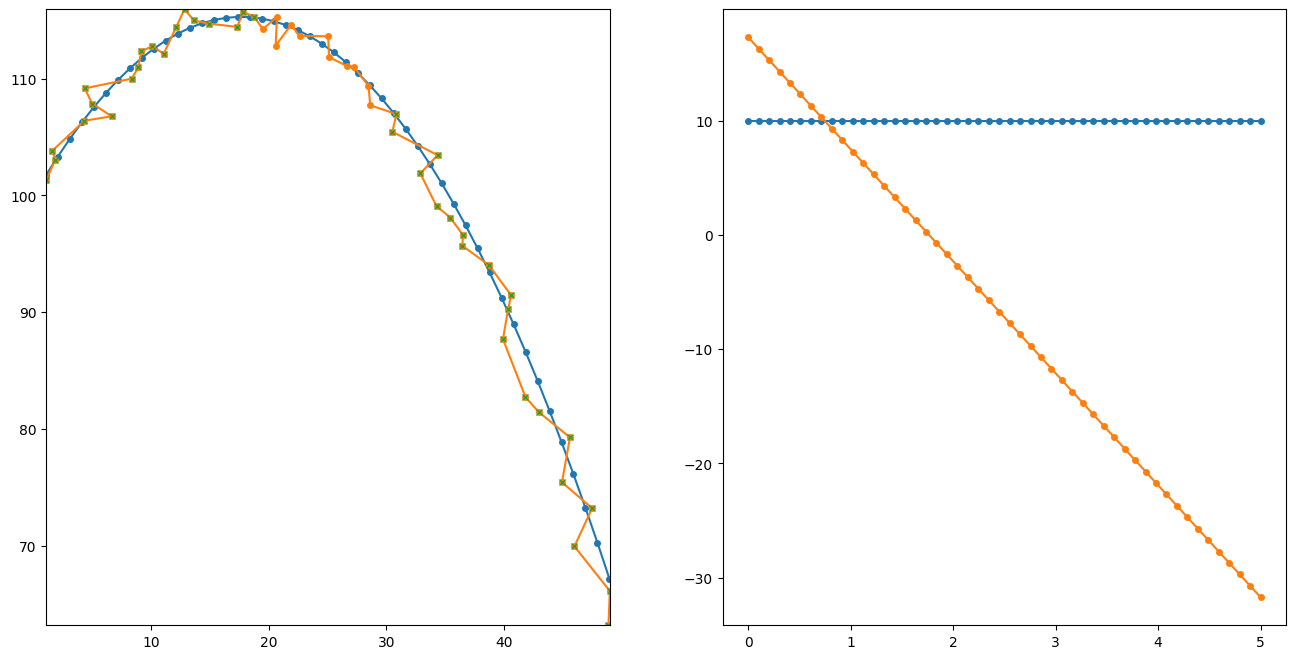

In [ ]:
mu_noise = [0,0]
cov_noise = [[1,0],[0,1]]
dt = 0.1
signal_c,time = projectile(20,60,100,dt,5)
signal = signal_c[[0,1]]
signal_n = noise_observation(signal,mu_noise,cov_noise)
signal_m = hide_observations(signal_n,2,1,0.1)

fig, (ax,ax1) = plt.subplots(1,2,figsize = (16,8))
ax.plot(signal[0],signal[1],'o',ls = '-',markersize = 4)
ax.plot(signal_n[0],signal_n[1],'o',ls = '-',markersize = 4)
ax.plot(signal_m[0],signal_m[1],'x',markersize = 4)
min_y = min(signal_n[1])
min_x = min(signal_n[0])
max_y = max(signal_n[1])
max_x = max(signal_n[0])
# print(min_y,max_y)
ax.set(ylim=(min_y,max_y),xlim=(min_x,max_x))
ax1.plot(time,signal_c[2],'o',ls = '-',markersize = 4)
ax1.plot(time,signal_c[3],'o',ls = '-',markersize = 4)

In [ ]:
class KalmanFilter(object):
    def __init__(self, dt, g = 9.81,initial_state = np.matrix([[0,0,0,0]]).T,Q = np.diag([1,1,1,1]),R = np.diag([1,1])):
        # Define sampling time
        self.dt = dt
        # Define the  control input variables
        self.u = np.matrix([0,g,0]).T
        # Intial State
        self.x = initial_state
        # Define the State Transition Matrix A
        self.A = np.matrix([[1, 0, self.dt, 0],
                            [0, 1, 0, self.dt],
                            [0, 0, 1, 0],
                            [0, 0, 0, 1]])
        # Define the Control Input Matrix B
        self.B = np.matrix([[0,0,0],
                            [0,-0.5*self.dt**2,0],
                            [0,0,0],
                            [0,-self.dt,0]])
        # Define Measurement Mapping Matrix
        self.H = np.matrix([[1, 0, 0, 0],
                            [0, 1, 0, 0]])
        #Initial Process Noise Covariance
        self.Q = Q
        #Initial Measurement Noise Covariance
        self.R = R
        #Initial Covariance Matrix
        self.P = np.eye(self.A.shape[1])

    def predict(self):
        # Refer to :Eq.(9) and Eq.(10)  in https://machinelearningspace.com/object-tracking-simple-implementation-of-kalman-filter-in-python/?preview_id=1364&preview_nonce=52f6f1262e&preview=true&_thumbnail_id=1795
        # Update time state
        #x_k =Ax_(k-1) + Bu_(k-1)     Eq.(9)
        self.x = np.dot(self.A, self.x) + np.dot(self.B, self.u)
        # Calculate error covariance
        # P= A*P*A' + Q               Eq.(10)
        self.P = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q
        # print(f'Predict: {self.x} size: {self.x.shape}')
        return self.x[0:2]

    def update(self, z):
        # Refer to :Eq.(11), Eq.(12) and Eq.(13)  in https://machinelearningspace.com/object-tracking-simple-implementation-of-kalman-filter-in-python/?preview_id=1364&preview_nonce=52f6f1262e&preview=true&_thumbnail_id=1795
        # S = H*P*H'+R
        S = np.dot(self.H, np.dot(self.P, self.H.T)) + self.R
        # Calculate the Kalman Gain
        # K = P * H'* inv(H*P*H'+R)
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))  #Eq.(11)
        #print(K)
        print(np.linalg.norm(K))
        self.x = self.x + np.dot(K, (z - np.dot(self.H, self.x)))  #Eq.(12)
        I = np.eye(self.H.shape[1])
        # Update error covariance matrix
        self.P = (I - (K * self.H)) * self.P   #Eq.(13)
        # print(f'Update: {self.x} size: {self.x.shape}')
        return self.x[0:2]

50
1.025954545989959
0.6698248701304491
0.6369107011936658
0.6894131824044321
0.7378723847678252
0.7565770845211351
0.7461270464944629
0.715464350103621
0.6738595365659024
0.6281969414882674
0.582767845931049
0.5398952446162272
0.5006286834424516
0.46527361789565946
0.4337377655226268
0.4057390013259399
0.3809226130720656
0.35892360510528554
0.3393973014364143
error
0.3220323774226213
error
0.30655455250540853
error
0.29272559843654217
error
0.28034022465093505
error
0.2692222076451639
error
0.25922046194619
error
0.2502053824024296
error
0.24206559011077025
error
0.23470511204943836
error
0.22804097465462056
error
0.22200117006501452
error
0.21652294710169898
error
0.2115513798089018
error
0.2070381705035227
error
0.20294064961632324
error
0.1992209400597394
error
0.1958452589096591
error
0.1927833336359704
error
0.19000791391567703
error
0.18749436324834023
error
0.18522031723590215
0.18316539756701353
0.18131097253726428
0.1796399564110364
0.1781366411482485
0.17678655503028054
0.17

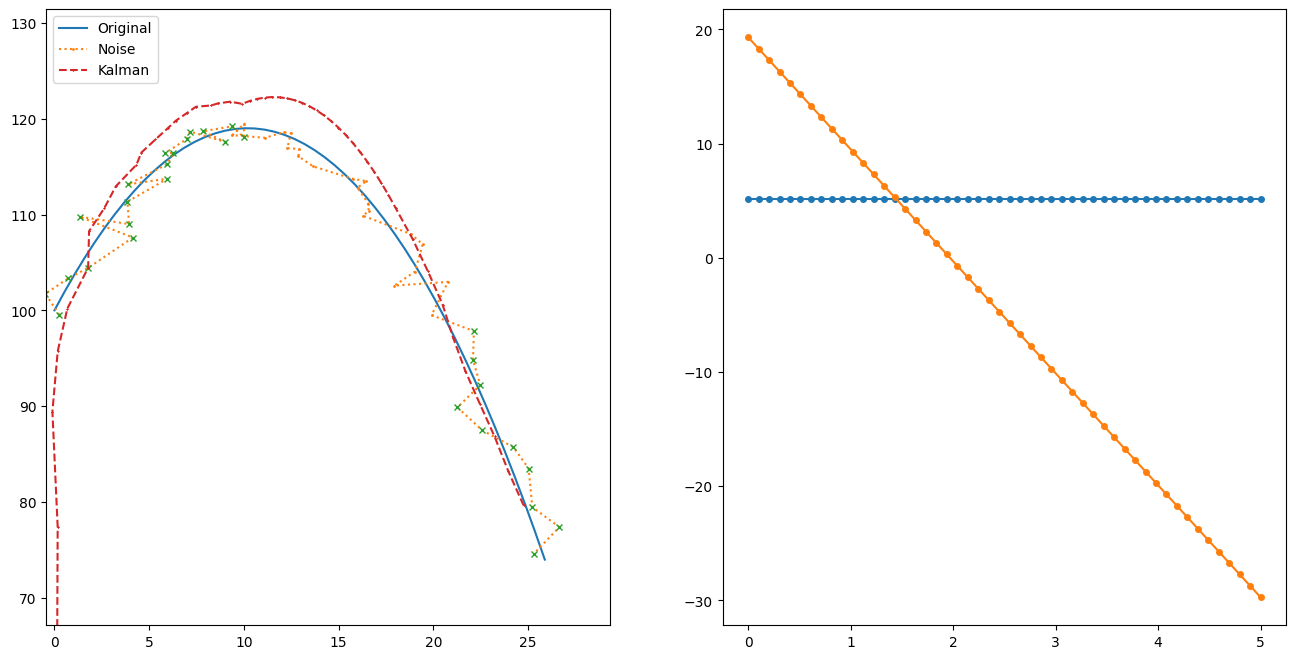

In [ ]:
error_value = -999999
g = 9.81
dt = 0.1
duration = 5
height = 100
speed = 20
angle = 75
t_0_dropout = 2
duration_dropout = 2
mu_noise = [0,0]
cov_noise = [[0.5,0],[0,0.5]]
signal_c,time = projectile(speed,angle,height,dt,duration)
signal = signal_c[[0,1]]
signal_n = noise_observation(signal,mu_noise,cov_noise)
signal_m = hide_observations(signal_n,t_0_dropout,duration_dropout,dt,error_value=error_value)

x_init = np.matrix([[0],[0],[0],[0]])
Q = np.diag([0.001,0.001,0.001,0.001])
R = np.diag([0.5,0.3])
KF = KalmanFilter(dt,g,initial_state=x_init,Q=Q,R=R)

print(len(time))
x_f = []
y_f = []

for i in range(len(time)):
    # print(time[i])
    x_o = signal[0,i]
    y_o = signal[1,i]
    # print(f'real position x: {x_o} y: {y_o}')
    x_n = signal_m[0,i]
    y_n = signal_m[1,i]
    if y_n == error_value:
        print('error')
        x_n = float(x1)
        y_n = float(y1)
    # print(f'noise position x: {x_n} y: {y_n}')
    pos = np.matrix([x_n,y_n]).T
    # print(pos.shape)
    # Predict
    (x, y) = KF.predict()
    # print(f'predicted position x: {x} y: {y}')
    # Draw a rectangle as the predicted object position
    # Update
    (x1, y1) = KF.update(pos)
    #x1 = x1[0]
    #y1 = y1[0]
    #print(f'updated position x: {x1} y: {y1}')
    x_f.append(float(x))
    y_f.append(float(y))
f_pos = np.stack((x_f,y_f))

fig, (ax,ax1) = plt.subplots(1,2,figsize = (16,8))
ax.plot(signal[0],signal[1],ls = '-',markersize = 1,label = 'Original')
ax.plot(signal_n[0],signal_n[1],'o',ls=':',markersize = 1,label = 'Noise')
ax.plot(signal_m[0],signal_m[1],'x',markersize = 4)
ax.plot(f_pos[0],f_pos[1],'x',ls = '--',markersize = 1,label = 'Kalman')
ax.legend(loc = 'upper left')
min_y = min(signal_n[1])
min_x = min(signal_n[0])
max_y = max(signal_n[1])
max_x = max(signal_n[0])
print(min_y,max_y)
print(min_x,max_x)
ax.set(ylim=(min_y-min_y*0.1,max_y+0.1*max_y),xlim=(min_x-min_x*0.1,max_x+0.1*max_x))
ax1.plot(time,signal_c[2],'o',ls = '-',markersize = 4)
ax1.plot(time,signal_c[3],'o',ls = '-',markersize = 4)


In [ ]:
kf = KalmanFilter(dt)

predictions = []
measurements = []
for i in range(signal_n.shape[1]):
    # Mesurement
    if i == 0:
        x = x_0
    else:
        x = signal_n[:,i]
    z = kf.H * x + np.random.normal(0, 50)
    print(z)
    measurements.append(z.item(0))
    k = kf.predict()
    predictions.append(k[0])
    kf.update(z.item(0))

print(measurements)
# fig = plt.figure()

# fig.suptitle('Example of Kalman filter for tracking a moving object in 1-D', fontsize=20)

# plt.plot(t, measurements, label='Measurements', color='b',linewidth=0.5)

# plt.plot(t, np.array(real_track), label='Real Track', color='y', linewidth=1.5)
# plt.plot(t, np.squeeze(predictions), label='Kalman Filter Prediction', color='r', linewidth=1.5)

# plt.xlabel('Time (s)', fontsize=20)
# plt.ylabel('Position (m)', fontsize=20)
# plt.legend()
# plt.show()


[[-55.71301244]
 [-55.71301244]]


ValueError: shapes (2,4) and (1,2) not aligned: 4 (dim 1) != 1 (dim 0)

In [ ]:
# Iterate through the simulation.
# These are arrays to store the data points we want to plot at the end.
x = []
y = []
nx = []
ny = []
kx = []
ky = []

for i in range(signal_n.shape[1]):
    x.append(signal_n[0][i])
    y.append(signal_n[1][i])
    newestX = signal_n[0][i]
    newestY = signal_n[1][i]
    nx.append(newestX)
    ny.append(newestY)
    # Iterate the cannon simulation to the next timeslice.
    kx.append(kF.GetCurrentState()[0,0])
    ky.append(kF.GetCurrentState()[2,0])
    kF.Step(B,np.matrix([[newestX],[0],[newestY],[0]]))

# Plot all the results we got.
pylab.plot(x,y,'-',nx,ny,':',kx,ky,'--')
pylab.xlabel('X position')
pylab.ylabel('Y position')
pylab.title('Measurement of a Cannonball in Flight')
pylab.legend(('true','measured','kalman'))
pylab.show()

ValueError: shapes (4,3) and (4,3) not aligned: 3 (dim 1) != 4 (dim 0)

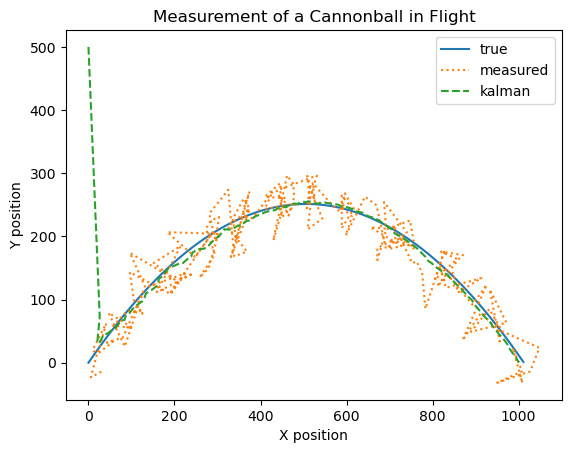

In [ ]:
# kalman2.py
# written by Greg Czerniak (email is greg {aT] czerniak [dOt} info )
#
# Implements a multi-variable linear Kalman filter.
#
# Note: This code is part of a larger tutorial "Kalman Filters for Undergrads"
# located at http://greg.czerniak.info/node/5.

import pylab
import math
import random
import numpy

# Implements a linear Kalman filter.
class KalmanFilterLinear:
  def __init__(self,_A, _B, _H, _x, _P, _Q, _R):
    self.A = _A                      # State transition matrix.
    self.B = _B                      # Control matrix.
    self.H = _H                      # Observation matrix.
    self.current_state_estimate = _x # Initial state estimate.
    self.current_prob_estimate = _P  # Initial covariance estimate.
    self.Q = _Q                      # Estimated error in process.
    self.R = _R                      # Estimated error in measurements.
  def GetCurrentState(self):
    return self.current_state_estimate
  def Step(self,control_vector,measurement_vector):
    #---------------------------Prediction step-----------------------------
    predicted_state_estimate = self.A * self.current_state_estimate + self.B * control_vector
    predicted_prob_estimate = (self.A * self.current_prob_estimate) * numpy.transpose(self.A) + self.Q
    #--------------------------Observation step-----------------------------
    innovation = measurement_vector - self.H*predicted_state_estimate
    innovation_covariance = self.H*predicted_prob_estimate*numpy.transpose(self.H) + self.R
    #-----------------------------Update step-------------------------------
    kalman_gain = predicted_prob_estimate * numpy.transpose(self.H) * numpy.linalg.inv(innovation_covariance)
    self.current_state_estimate = predicted_state_estimate + kalman_gain * innovation
    # We need the size of the matrix so we can make an identity matrix.
    size = self.current_prob_estimate.shape[0]
    # eye(n) = nxn identity matrix.
    self.current_prob_estimate = (numpy.eye(size)-kalman_gain*self.H)*predicted_prob_estimate

# Simulates the classic physics problem of a cannon shooting a ball in a
# parabolic arc.  In addition to giving "true" values back, you can also ask
# for noisy values back to test Kalman filters.
class Cannon:
  #--------------------------------VARIABLES----------------------------------
  angle = 45 # The angle from the ground to point the cannon.
  muzzle_velocity = 100 # Muzzle velocity of the cannon.
  gravity = [0,-9.81] # A vector containing gravitational acceleration.
  # The initial velocity of the cannonball
  velocity = [muzzle_velocity*math.cos(angle*math.pi/180), muzzle_velocity*math.sin(angle*math.pi/180)]
  loc = [0,0] # The initial location of the cannonball.
  acceleration = [0,0] # The initial acceleration of the cannonball.
  #---------------------------------METHODS-----------------------------------
  def __init__(self,_timeslice,_noiselevel):
    self.timeslice = _timeslice
    self.noiselevel = _noiselevel
  def add(self,x,y):
    return x + y
  def mult(self,x,y):
    return x * y
  def GetX(self):
    return self.loc[0]
  def GetY(self):
    return self.loc[1]
  def GetXWithNoise(self):
    return random.gauss(self.GetX(),self.noiselevel)
  def GetYWithNoise(self):
    return random.gauss(self.GetY(),self.noiselevel)
  def GetXVelocity(self):
    return self.velocity[0]
  def GetYVelocity(self):
    return self.velocity[1]
  # Increment through the next timeslice of the simulation.
  def Step(self):
    # We're gonna use this vector to timeslice everything.
    timeslicevec = [self.timeslice,self.timeslice]
    # Break gravitational force into a smaller time slice.
    sliced_gravity = list(map(self.mult,self.gravity,timeslicevec))
    # The only force on the cannonball is gravity.
    sliced_acceleration = sliced_gravity
    # Apply the acceleration to velocity.
    self.velocity = list(map(self.add, self.velocity, sliced_acceleration))
    sliced_velocity = list(map(self.mult, self.velocity, timeslicevec ))
    # Apply the velocity to location.
    self.loc = list(map(self.add, self.loc, sliced_velocity))
    # Cannonballs shouldn't go into the ground.
    if self.loc[1] < 0:
      self.loc[1] = 0

#=============================REAL PROGRAM START================================
# Let's go over the physics behind the cannon shot, just to make sure it's
# correct:
# sin(45)*100 = 70.710 and cos(45)*100 = 70.710
# vf = vo + at
# 0 = 70.710 + (-9.81)t
# t = 70.710/9.81 = 7.208 seconds for half
# 14.416 seconds for full journey
# distance = 70.710 m/s * 14.416 sec = 1019.36796 m

timeslice = 0.1 # How many seconds should elapse per iteration?
iterations = 144 # How many iterations should the simulation run for?
# (notice that the full journey takes 14.416 seconds, so 145 iterations will
# cover the whole thing when timeslice = 0.10)
noiselevel = 30  # How much noise should we add to the noisy measurements?
muzzle_velocity = 100 # How fast should the cannonball come out?
angle = 45 # Angle from the ground.

# These are arrays to store the data points we want to plot at the end.
x = []
y = []
nx = []
ny = []
kx = []
ky = []

# Let's make a cannon simulation.
c = Cannon(timeslice,noiselevel)

speedX = muzzle_velocity*math.cos(angle*math.pi/180)
speedY = muzzle_velocity*math.sin(angle*math.pi/180)

# This is the state transition vector, which represents part of the kinematics.
# 1, ts, 0,  0  =>  x(n+1) = x(n) + vx(n)
# 0,  1, 0,  0  => vx(n+1) =        vx(n)
# 0,  0, 1, ts  =>  y(n+1) =              y(n) + vy(n)
# 0,  0, 0,  1  => vy(n+1) =                     vy(n)
# Remember, acceleration gets added to these at the control vector.
state_transition = numpy.matrix([[1,timeslice,0,0],[0,1,0,0],[0,0,1,timeslice],[0,0,0,1]])

control_matrix = numpy.matrix([[0,0,0,0],[0,0,0,0],[0,0,1,0],[0,0,0,1]])
# The control vector, which adds acceleration to the kinematic equations.
# 0          =>  x(n+1) =  x(n+1)
# 0          => vx(n+1) = vx(n+1)
# -9.81*ts^2 =>  y(n+1) =  y(n+1) + 0.5*-9.81*ts^2
# -9.81*ts   => vy(n+1) = vy(n+1) + -9.81*ts
control_vector = numpy.matrix([[0],[0],[0.5*-9.81*timeslice*timeslice],[-9.81*timeslice]])

# After state transition and control, here are the equations:
#  x(n+1) = x(n) + vx(n)
# vx(n+1) = vx(n)
#  y(n+1) = y(n) + vy(n) - 0.5*9.81*ts^2
# vy(n+1) = vy(n) + -9.81*ts
# Which, if you recall, are the equations of motion for a parabola.  Perfect.

# Observation matrix is the identity matrix, since we can get direct
# measurements of all values in our example.
observation_matrix = numpy.eye(4)

# This is our guess of the initial state.  I intentionally set the Y value
# wrong to illustrate how fast the Kalman filter will pick up on that.
initial_state = numpy.matrix([[0],[speedX],[500],[speedY]])

initial_probability = numpy.eye(4)

process_covariance = numpy.zeros(4)
measurement_covariance = numpy.eye(4)*0.2

kf = KalmanFilterLinear(state_transition, control_matrix, observation_matrix, initial_state, initial_probability, process_covariance, measurement_covariance)

# Iterate through the simulation.
for i in range(iterations):
    x.append(c.GetX())
    y.append(c.GetY())
    newestX = c.GetXWithNoise()
    newestY = c.GetYWithNoise()
    nx.append(newestX)
    ny.append(newestY)
    # Iterate the cannon simulation to the next timeslice.
    c.Step()
    kx.append(kf.GetCurrentState()[0,0])
    ky.append(kf.GetCurrentState()[2,0])
    kf.Step(control_vector,numpy.matrix([[newestX],[c.GetXVelocity()],[newestY],[c.GetYVelocity()]]))

# Plot all the results we got.
pylab.plot(x,y,'-',nx,ny,':',kx,ky,'--')
pylab.xlabel('X position')
pylab.ylabel('Y position')
pylab.title('Measurement of a Cannonball in Flight')
pylab.legend(('true','measured','kalman'))
pylab.show()